# Data Science Lab - Task 2

> Author: Alexandre Charoy, 448140
>
> Version 1
>
> Date: 29.04.2019

## Read Data

In [20]:
import pandas as pd
from lxml import objectify

# Get columns from XML

path = '../datasets/iris/data_someMissing.all.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()
header = root.column_header

columns = []

for elt in header.getchildren():
    columns.append({'name': elt.get('name'), 'type': elt.get('type')})

names = [c['name'] for c in columns]

# Get data tables

original = pd.read_csv('../datasets/iris/data.all', sep=' ', header=None, names=names)

table = pd.read_csv('../datasets/iris/data_someMissing.all', sep=' ', header=None, names=names)

table_setosa      = table[table['Class'].str.contains('setosa')]
table_versicolora = table[table['Class'].str.contains('versicolor')]
table_virginica   = table[table['Class'].str.contains('virginica')]

## Missing Values

The two basic methods of handling missing data are deletion and imputation.

### Count Missing Values

In [21]:
(table == '?').sum()

Sepal-length    1
Sepal-width     1
Petal-length    1
Petal-width     2
Class           1
dtype: int64

## Deletion

As there are only few and seemingly random missing values across different rows and columns, deletion should allow to produce a reduced but still usable data set.

In [22]:
reduced_table = table

for name in names:
    reduced_table = reduced_table[reduced_table[name] != '?']
    if name != "Class":
        reduced_table[name] = pd.to_numeric(reduced_table[name])
reduced_table.reset_index(drop=True, inplace=True)

print("Remaining rows: {}".format(len(reduced_table.index)))

Remaining rows: 145


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Deleting all rows containing missing values dropped 5 rows out of 150, which is 3% of all rows. Its is probable that the data set is not significantly worse than before, as only a small number of samples have been lost.

Let's visualize the remaining data set as a scatter matrix as done in lab task 1:

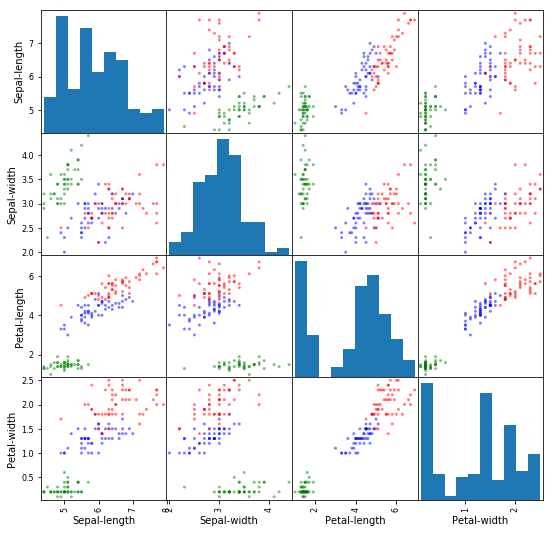

In [23]:
color_map = {"Iris-setosa": "Green", 
               "Iris-versicolor": "Blue", 
               "Iris-virginica": "Red"}
              
colors = reduced_table["Class"].map(lambda x: color_map.get(x))

pd.plotting.scatter_matrix(reduced_table, color=colors, figsize=(9, 9));

At first look, the reduced data set is not significantly worse than the original data set. Let's take a look at the statistical properties of this reduced data set next.

### Statistical Properties

In [24]:
stats = []

for name in names:
    if (name == 'Class'):
        continue
    column_original = original[name]
    column_reduced = reduced_table[name]
    stats.append({'mean (reduced)': column_reduced.mean(), 'mean (original)': column_original.mean(), 'difference': column_original.mean()-column_reduced.mean()})

statsdf = pd.DataFrame(stats, index=names[:-1])
print(statsdf)

              difference  mean (original)  mean (reduced)
Sepal-length   -0.027011         5.843333        5.870345
Sepal-width     0.013885         3.057333        3.043448
Petal-length   -0.082000         3.758000        3.840000
Petal-width    -0.034460         1.199333        1.233793


We can see that the statistical properties of the reduced data set differ from the original data set's properties, in the case of petal length by `0.08`.

## Imputation

When performing imputation, missing values are filled in with new values. The question is what value to fill in. Depending on the type of data, different imputation methods can make sense: mean values, median values, linear interpolation, a default categorical level...

We will attempt to impute missing numerical values with mean values.

As we have seen in [Count Missing Values](#Count-Missing-Values), there is also a row with a missing class variable. Since that feature vector only misses the class variable, but all numerical values are present, we will attempt to classify the data point by comparing it to the mean values of other data points.

### Numerical Values

We now replace the missing numerical values with the class median that we already computed in [Deletion#Statistical Properties](#Statistical-Properties).

In [25]:
corrected_table = table.copy()

for name in names:
    if (name == 'Class'):
        continue
    corrected_table[name] = corrected_table[name].replace('?', statsdf['mean (reduced)'][name])
    corrected_table[name] = corrected_table[name].astype("float64")
corrected_table.reset_index(drop=True, inplace=True)

corrected_table_1 = corrected_table[corrected_table['Class'] != '?']

We will now compute the statistical properties of this "corrected" data set, and compare it to the statistical properties of the original set:

In [26]:
stats_corr = []

for name in names:
    if (name == 'Class'):
        continue
    column_original = original[name]
    column_corrected = corrected_table_1[name]
    stats_corr.append({'mean (corrected)': column_corrected.mean(), 'mean (original)': column_original.mean(), 'difference': column_original.mean()-column_corrected.mean()})

stats_corrected = pd.DataFrame(stats_corr, index=names[:-1])
print(stats_corrected)

              difference  mean (corrected)  mean (original)
Sepal-length   -0.007474          5.850808         5.843333
Sepal-width     0.005364          3.051969         3.057333
Petal-length   -0.031530          3.789530         3.758000
Petal-width    -0.021926          1.221259         1.199333


As we can see, the statisctical properties of this "corrected" data set are closer to the original data set's properties as the properties of the previous "reduced" data set. In this case, the data set with imputed values is truer to the original than the data set with deleted values.

### Missing Class

We will now try to guess the class of the feature vector that is missing the class information.

In [27]:
missing_class = corrected_table[corrected_table['Class'] == '?']
print(missing_class)

means_corrected = []

for name in names:
    if (name == 'Class'):
        continue
    means_corrected.append({'mean (Iris-setosa)': corrected_table_1[corrected_table_1['Class'] == 'Iris-setosa'][name].mean(),
                           'mean (Iris-versicolor)': corrected_table_1[corrected_table_1['Class'] == 'Iris-versicolor'][name].mean(),
                           'mean (Iris-virginica)': corrected_table_1[corrected_table_1['Class'] == 'Iris-virginica'][name].mean()})

means_corrected = pd.DataFrame(means_corrected, index=names[:-1])
print(means_corrected)

   Sepal-length  Sepal-width  Petal-length  Petal-width Class
9           4.9          3.1           1.5          0.1     ?
              mean (Iris-setosa)  mean (Iris-versicolor)  \
Sepal-length            5.011640                   5.936   
Sepal-width             3.419254                   2.770   
Petal-length            1.511020                   4.260   
Petal-width             0.293216                   1.326   

              mean (Iris-virginica)  
Sepal-length                  6.588  
Sepal-width                   2.974  
Petal-length                  5.552  
Petal-width                   2.026  


Comparing the values of the feature vector with the missing class feature to the means of each class (from the available "corrected" data set) shows that it is closest to the iris setosa values. A look into the original data set show that this is correct, the feature vector is of the `Iris-setosa` class!